<a href="https://colab.research.google.com/github/KimYuri94/skipgram/blob/main/SEMANTICS2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. groundwork

In [ ]:
!pip install rdflib gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gensim.models import Word2Vec
from rdflib import Graph, URIRef
from rdflib import Literal
from concurrent.futures import ThreadPoolExecutor, as_completed
import random
import os
import pandas as pd

#1. data collection
LOD-A와 LOD-B로부터 RDF 트리플 데이터를 로드,  
각각의 subject, predicate, and object을 추출  
영어가 아닌 데이터는 제외하였다.


In [ ]:
def load_rdf_data(file_path):
    graph = Graph()
    graph.parse(file_path, format=os.path.splitext(file_path)[1][1:])
    return graph
g_a = load_rdf_data('/content/drive/MyDrive/dbpedia_new.ttl')
g_b = load_rdf_data('/content/drive/MyDrive/yago_10000.ttl')

In [ ]:
def extract_triples_with_language_filter(graph, language='en'):
    triples = []
    for subj, pred, obj in graph:
        if isinstance(obj, Literal) and obj.language == language:
            triples.append((str(subj), str(pred), str(obj)))
        elif not isinstance(obj, Literal):
            triples.append((str(subj), str(pred), str(obj)))
    return triples

# 사용 예:
triples_a = extract_triples_with_language_filter(g_a, 'en')
triples_b = extract_triples_with_language_filter(g_b, 'en')

all_triples = triples_a + triples_b

triples_a[:5], triples_b[:5]

([('http://dbpedia.org/ontology/areaUrban',
   'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
   'http://www.w3.org/2002/07/owl#DatatypeProperty'),
  ('http://dbpedia.org/ontology/ChristianPatriarch',
   'http://www.w3.org/2000/01/rdf-schema#label',
   'Christian Patriarch'),
  ('http://dbpedia.org/ontology/GrandPrix',
   'http://www.w3.org/2000/01/rdf-schema#subClassOf',
   'http://dbpedia.org/ontology/SportsEvent'),
  ('http://dbpedia.org/ontology/area',
   'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
   'http://www.w3.org/1999/02/22-rdf-syntax-ns#Property'),
  ('http://dbpedia.org/ontology/areaLand',
   'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
   'http://www.w3.org/1999/02/22-rdf-syntax-ns#Property')],
 [('http://yago-knowledge.org/resource/Reliquary_Bust_Q29291448',
   'http://www.w3.org/2000/01/rdf-schema#subClassOf',
   'http://yago-knowledge.org/resource/Reliquary'),
  ('http://yago-knowledge.org/resource/Ticket_machine',
   'http://www.w3.org/2000/01/rdf-sch

#2. data transformation
RDF트리플을 skip-gram모델의 입력 형식에 맞게 변환  
이 과정에서 각 subject, predicate, object를 분리하여 리스트 형태로 저장

In [ ]:
training_data = []

#각각의 subject, predicate, object에 대해 embedding을 형성해야 하므로:
for subj, pred, obj in all_triples:
    training_data.append([subj, pred])
    training_data.append([subj, obj])

    training_data.append([pred, subj])
    training_data.append([pred, obj])

    training_data.append([obj, subj])
    training_data.append([obj, pred])

#3. model training: skip-gram
skip-gram모델을 사용, 트리플 데이터에 대한 임베딩을 학습한다.  
word2vec모델을 사용한다.  
negative sampling 손실함수를 사용하여 최적화한다.  

In [ ]:
model = Word2Vec(
      sentences=training_data,
      vector_size=100,
      window=1,
      min_count=1,
      sg=1,
      workers=8,
      negative=10,
      alpha=0.03,
      min_alpha=0.0007)

model.train(training_data, total_examples=model.corpus_count, epochs=100)

(14550703, 20282400)

#4. embedding learning
skip-gram모델로부터 subject, predicate, object의 벡터 표현을 학습 -> 이 임베딩은 단어간의 의미적 유사성을 반영한다.  
각 엔티티와 해당 임베딩 벡터에 대한 표를 출력해서 임베딩이 잘 되었는지 확인해본다.

In [ ]:
data = []
for entity in set().union(*training_data):
    if entity in model.wv:
        data.append({"Entity": entity, "Embedding Vector": model.wv[entity].tolist()})

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)

df = pd.DataFrame(data)

print(df.head())

                                                        Entity  \
0                  http://yago-knowledge.org/resource/Androgen   
1                      http://yago-knowledge.org/resource/VTOL   
2                 http://dbpedia.org/datatype/zimbabweanDollar   
3  http://yago-knowledge.org/resource/Heddle_Pulley_Q111744113   
4                 http://yago-knowledge.org/resource/Q56355995   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#5. link prediction
학습된 임베딩을 사용, RDF트리플 간의 유사성을 계산(cosine similarity)하고 새로운 연결을 예측한다.  
유사성이 높은 엔티티를 찾아 출력한다.  
링크 예측의 경우 gensim의 similarity함수 사용시 30분의 시간이 소모되었지만, numpy를 사용하여 벡터 간 유사성을 직접 계산함으로써 이를 10분까지 줄일 수 있었다.

In [ ]:
def find_similar_entities(entity, model, topn=5):
    if entity in model.wv:
        similar_entities = model.wv.most_similar(entity, topn=topn)
        return entity, similar_entities
    else:
        return entity, None

unique_entities = list(set().union(*training_data))
example_entities = random.sample(unique_entities, 10)

for entity in example_entities:
    entity, similar_entities = find_similar_entities(entity, model)
    if similar_entities:
        print(f"Similar entities to '{entity}':")
        for similar_entity, similarity in similar_entities:
            print(f"  {similar_entity} (Similarity: {similarity})")
        print("----------------------------------------------------")
    else:
        print(f"Entity '{entity}' not found in the model.")

Similar entities to 'http://www.wikidata.org/entity/P569':
  https://d-nb.info/standards/elementset/gnd#dateOfBirth (Similarity: 0.9982573390007019)
  http://www.wikidata.org/entity/P1477 (Similarity: 0.9669414758682251)
  http://www.wikidata.org/entity/P106 (Similarity: 0.9536794424057007)
  http://www.wikidata.org/entity/P1562 (Similarity: 0.9290705323219299)
  https://dblp.org/rdf/schema-2020-07-01#authoredBy (Similarity: 0.9284487366676331)
----------------------------------------------------
Similar entities to 'http://yago-knowledge.org/resource/Safety_instrumented_system':
  http://yago-knowledge.org/resource/Circuit_breaker (Similarity: 0.9389173984527588)
  http://yago-knowledge.org/resource/Protective_Device_Q3030569 (Similarity: 0.8943142294883728)
  http://yago-knowledge.org/resource/Switch (Similarity: 0.8910049796104431)
  http://yago-knowledge.org/resource/Power_Electronic_Component_Q64706737 (Similarity: 0.868134617805481)
  http://yago-knowledge.org/resource/Oil_Circui

In [ ]:
def create_links_with_high_similarity(triples_a, triples_b, model, threshold=0.7):
    new_links = []
    for subj_a, pred_a, obj_a in triples_a:
        for subj_b, _, _ in triples_b:
            if subj_a in model.wv and subj_b in model.wv:
                similarity = model.wv.similarity(subj_a, subj_b)
                if similarity > threshold:
                    new_links.append((subj_b, pred_a, obj_a, similarity))
    return new_links

new_links = create_links_with_high_similarity(triples_a, triples_b, model)
for subj, pred, obj, sim in new_links:
    print(f"New link created: ({subj} - {pred} - {obj} : {sim})")


New link created: (http://yago-knowledge.org/schema#element_219 - http://www.w3.org/2000/01/rdf-schema#range - http://www.w3.org/2001/XMLSchema#gYear : 0.7042620778083801)
New link created: (http://yago-knowledge.org/schema#element_117 - http://www.w3.org/ns/prov#wasDerivedFrom - http://mappings.dbpedia.org/index.php/OntologyProperty:activeYearsStartDateMgr : 0.7286341786384583)
New link created: (http://yago-knowledge.org/schema#element_155 - http://www.w3.org/ns/prov#wasDerivedFrom - http://mappings.dbpedia.org/index.php/OntologyProperty:activeYearsStartDateMgr : 0.7012758255004883)
New link created: (http://yago-knowledge.org/schema#element_203 - http://www.w3.org/ns/prov#wasDerivedFrom - http://mappings.dbpedia.org/index.php/OntologyProperty:activeYearsStartDateMgr : 0.7479305267333984)
New link created: (http://yago-knowledge.org/schema#element_159 - http://www.w3.org/ns/prov#wasDerivedFrom - http://mappings.dbpedia.org/index.php/OntologyProperty:bestYearWsop : 0.7030782699584961)

In [ ]:
import numpy as np

def create_links_with_high_similarity_optimized(triples_a, triples_b, model, threshold=0.7):
    new_links = []

    model_vocab = set(model.wv.index_to_key)
    triples_a_filtered = [(subj, pred, obj) for subj, pred, obj in triples_a if subj in model_vocab]
    triples_b_filtered = [subj for subj, _, _ in triples_b if subj in model_vocab]

    vectors_a = {subj: model.wv[subj] for subj, _, _ in triples_a_filtered}
    vectors_b = {subj: model.wv[subj] for subj in triples_b_filtered}

    for subj_a, pred_a, obj_a in triples_a_filtered:
        vector_a = vectors_a[subj_a]
        for subj_b in triples_b_filtered:
            vector_b = vectors_b[subj_b]
            similarity = np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
            if similarity > threshold:
                new_links.append((subj_b, pred_a, obj_a, similarity))

    return new_links

new_links = create_links_with_high_similarity_optimized(triples_a, triples_b, model)
for subj, pred, obj, sim in new_links:
    print(f"New link created: ({subj} - {pred} - {obj} : {sim})")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
New link created: (http://yago-knowledge.org/schema#HumanMadeGeographicalEntity_property_269 - http://www.w3.org/2000/01/rdf-schema#domain - http://dbpedia.org/ontology/Film : 0.7129341959953308)
New link created: (http://yago-knowledge.org/schema#Organization_property_165 - http://www.w3.org/2000/01/rdf-schema#domain - http://dbpedia.org/ontology/Film : 0.7504521012306213)
New link created: (http://yago-knowledge.org/schema#Class_property_10 - http://www.w3.org/2000/01/rdf-schema#domain - http://dbpedia.org/ontology/Film : 0.7238413095474243)
New link created: (http://yago-knowledge.org/schema#Organization_property_161 - http://www.w3.org/2000/01/rdf-schema#domain - http://dbpedia.org/ontology/Film : 0.7531093955039978)
New link created: (http://yago-knowledge.org/schema#Organization_property_165 - http://www.w3.org/2000/01/rdf-schema#domain - http://dbpedia.org/ontology/Film : 0.7504521012306213)
New link created: (http://yago-knowledge.org/schema#

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
New link created: (http://yago-knowledge.org/schema#AdministrativeArea_property_255 - http://www.w3.org/1999/02/22-rdf-syntax-ns#type - http://www.w3.org/2002/07/owl#DatatypeProperty : 0.7662469148635864)
New link created: (http://yago-knowledge.org/schema#Class_property_10 - http://www.w3.org/1999/02/22-rdf-syntax-ns#type - http://www.w3.org/2000/01/rdf-schema#Datatype : 0.7054426074028015)
New link created: (http://yago-knowledge.org/schema#Class_property_10 - http://www.w3.org/1999/02/22-rdf-syntax-ns#type - http://www.w3.org/2000/01/rdf-schema#Datatype : 0.7054426074028015)
New link created: (http://yago-knowledge.org/schema#Class_property_10 - http://www.w3.org/1999/02/22-rdf-syntax-ns#type - http://www.w3.org/2000/01/rdf-schema#Datatype : 0.7054426074028015)
New link created: (http://yago-knowledge.org/schema#element_302 - http://www.w3.org/2000/01/rdf-schema#range - http://www.w3.org/2001/XMLSchema#date : 0.7886409163475037)
New link created: 

#6. 시각화

In [ ]:
!pip install scikit-learn matplotlib

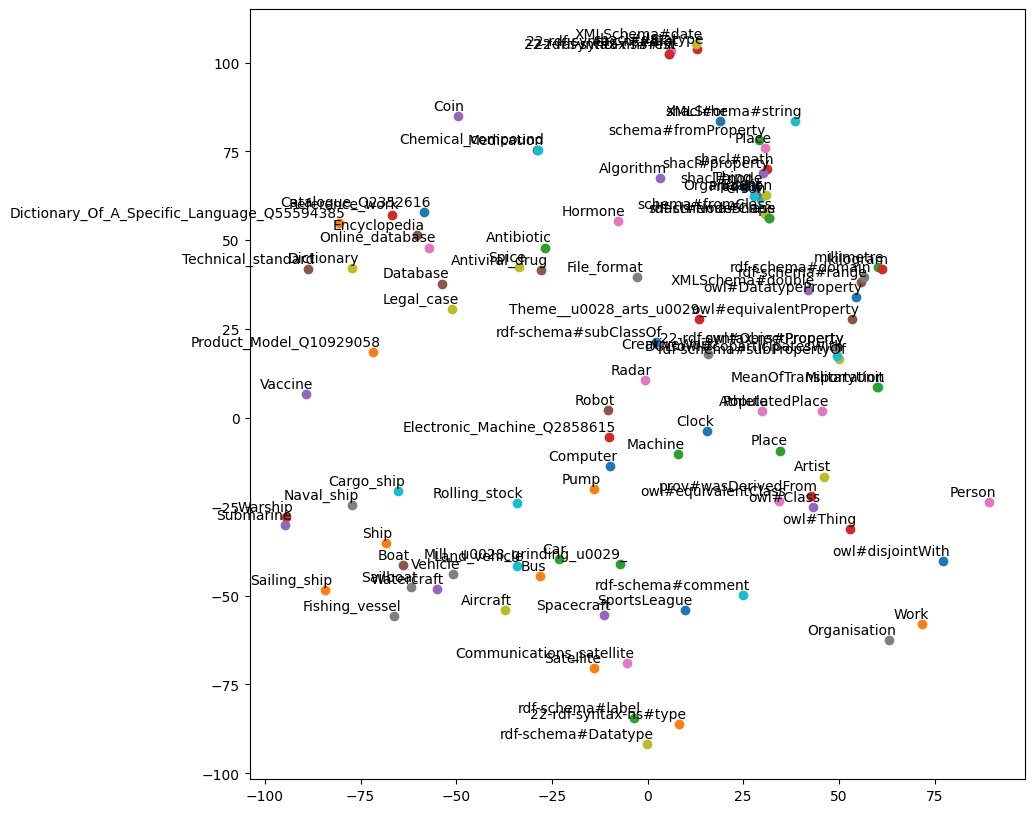

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

words = list(model.wv.index_to_key)
vectors = [model.wv[word] for word in words]

vectors = np.array(vectors)

tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(10, 10))
for i, word in enumerate(words[:100]):
    simplified_word = word.split('/')[-1]
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
    plt.annotate(simplified_word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.show()